In [34]:
import numpy as np
from IPython.display import display, HTML
import matplotlib.pyplot as plt
from collections import defaultdict
import pandas as pd
from tqdm.auto import trange
import seaborn as sns
from sklearn.metrics import normalized_mutual_info_score
import matplotlib.patches as mpatches
import pymc as pm
from scipy.stats import binom

In [3]:
def display_table(table, row_labels, col_labels):
    html = "<table>"
    html += "<tr><th></th><th>" + "</th><th>".join(col_labels) + "</th></tr>"
    for i, row in enumerate(table):
        html += "<tr><th>" + row_labels[i] + "</th><td>" + "</td><td>".join(map(str, row)) + "</td></tr>"
    html += "</table>"
    display(HTML(html))

def safelog(vals):
    with np.errstate(divide='ignore'):
        return np.log(vals)

def normalize(A):
    # if only one dimension do not transpose
    if len(A.shape) == 1:
        return A / A.sum()
    with np.errstate(divide='ignore'):
        return np.nan_to_num((A.T / A.sum(axis=1)).T)

def lex_to_str(l):
    return ''.join(map(str, l.reshape(l.shape[0] * l.shape[1])))

In [4]:
class BaseRSA:
    def __init__(self, contexts, costs, alpha, prior):
        self.contexts = contexts
        self.costs = costs
        self.alpha = alpha
        self.prior = prior
 
    def L_0(self, A, context=None):
        ''' Literal listener: normalizes the defined lexicon '''
        if context is None:
            return normalize(A * self.prior)
        else:
            return normalize(A * self.contexts[context] * self.prior)

    def S_p(self, A, context=None):
        ''' 
        Literal speaker: subtract cost from the defined lexicon 
        
        To-do:

        - there is a bug here, the cost should be subtracted from the literal listener,
        but for some reason it is not working as expected when subtracting, so I'm adding
        instead
        '''
        if context is None:
            return normalize(np.exp(self.alpha * (safelog(self.L_0(A, None).T) + self.costs)))
        else:
            return normalize(np.exp(self.alpha * (safelog(self.L_0(A, context).T) + self.costs)))

    def L_p(self, A, context=None):
        ''' Pragmatic listener: normalizes the defined lexicon receiver from the pragmatic speaker '''
        if context is None:
            return normalize(self.S_p(A, None).T * self.prior)
        else:
            return normalize(self.S_p(A, context).T * self.contexts[context] * self.prior)

In [5]:
class Agent(BaseRSA):
    def __init__(self, n_words, n_meanings, contexts, costs, alpha, prior):
        BaseRSA.__init__(self, contexts, costs, alpha, prior)
        self.lexicons = self.generate_lexicons(n_words, n_meanings)
        self.lexicons_norm = np.array([normalize(lexicon) for lexicon in self.lexicons]) 
        self.lexicon_probs = np.ones(len(self.lexicons)) / len(self.lexicons)

    @staticmethod
    def generate_lexicons(n_words, n_meanings):
        arrays =  np.array([list(map(int, list(np.binary_repr(i, width=n_words*n_meanings)))) for i in range(2**(n_words*n_meanings))])
        lexicons = arrays.reshape((2**(n_words*n_meanings), n_words, n_meanings))
        return lexicons[lexicons.sum(axis=1).min(axis=1) > 0]

    def speaker(self, meaning, context):
        lexicon = self.lexicons[np.random.choice(len(self.lexicons), p=self.lexicon_probs)]
        return self.S_p(lexicon, context)[meaning].argmax()
    
    def listener(self, message, context):
        lexicon = self.lexicons[np.random.choice(len(self.lexicons), p=self.lexicon_probs)]
        return self.L_p(lexicon, context)[message].argmax()
    
    def update_lexicon(self, message, meaning):
        ''' 
        Get the posterior distribution over lexicons given the message and meaning

        To-do:

        - Update on L_p instead of L_0?

        NB: adding random noise to prevent agents getting stuck in local optima 
        '''
        self.lexicon_probs = normalize(self.lexicon_probs * self.lexicons_norm[:, message, meaning] + 1e-5)
    
    def get_lexicon(self):
        return self.lexicons[self.lexicon_probs.argmax()], self.lexicon_probs.argmax()
    
    def L_p_max(self):
        return self.L_p(self.lexicons[self.lexicon_probs.argmax()], None)

### 1. Model 

In [6]:
N_MEANINGS = 3
CONTEXTS = np.array([[1, 1, 0], [1, 0, 1]]) # should we normalize?
COSTS = np.array([0, 10])
ALPHA = 5
context_meanings = {0: [0, 1], 1: [0], 2: [1]}
PRIOR = normalize(np.array([1, 1, 1]))
# 0 -- star 
# 1 -- circle
# 2 -- triangle

posts = []
logs_comp = []
lexicons_L_p = []
lexicons = []

for tr in trange(100):
    agent1 = Agent(n_words = 2, n_meanings = N_MEANINGS, contexts = CONTEXTS, costs = COSTS, alpha = ALPHA, prior = PRIOR)
    agent2 = Agent(n_words = 2, n_meanings = N_MEANINGS, contexts = CONTEXTS, costs = COSTS, alpha = ALPHA, prior = PRIOR)
    logs = defaultdict(dict)
    for _ in range(100):
        meaning = np.random.randint(0, N_MEANINGS)
        context = np.random.choice(context_meanings[meaning])
        logs[_] = {'trial': tr, 'context': context, 'meaning': meaning}
        if _ % 2 == 0:
            message = agent1.speaker(meaning, context)
            meaning_guess = agent2.listener(message, context)
            logs[_]['message'] = message
            logs[_]['meaning_guess'] = meaning_guess
            logs[_]['lexicon'] = lex_to_str(agent1.get_lexicon()[0])
            if meaning_guess == meaning:
                logs[_]['correct'] = True
                agent1.update_lexicon(message, meaning)
                agent2.update_lexicon(message, meaning)
            else:
                logs[_]['correct'] = False
        else:
            message = agent2.speaker(meaning, context)
            meaning_guess = agent1.listener(message, context)  
            logs[_]['message'] = message
            logs[_]['meaning_guess'] = meaning_guess
            logs[_]['lexicon'] = lex_to_str(agent1.get_lexicon()[0])
            if meaning_guess == meaning:
                logs[_]['correct'] = True
                agent1.update_lexicon(message, meaning)
                agent2.update_lexicon(message, meaning)
            else:
                logs[_]['correct'] = False
    lexicons.append(agent1.get_lexicon())
    lexicons.append(agent2.get_lexicon())
    logs_comp.append(logs)
    posts.append(agent1.lexicon_probs)
    posts.append(agent2.lexicon_probs)

  0%|          | 0/100 [00:00<?, ?it/s]/var/folders/1c/pphtjl397rnbdcp94xmwzkqr0000gn/T/ipykernel_62591/2855963600.py:18: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num((A.T / A.sum(axis=1)).T)
100%|██████████| 100/100 [00:01<00:00, 70.81it/s]


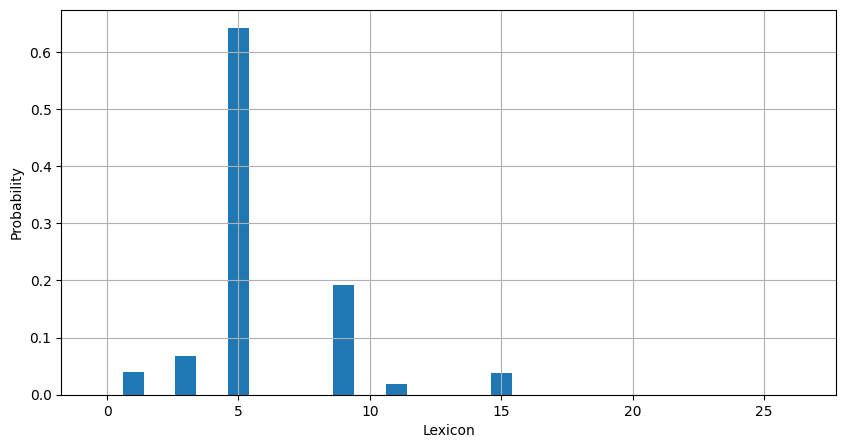

In [7]:
# sum over posts
lexicon_probs = normalize(np.sum(posts, axis=0))

# plot the posterior distribution of the lexicons
plt.figure(figsize=(10, 5))
plt.bar(np.arange(len(lexicon_probs)), lexicon_probs)
plt.xlabel('Lexicon')
plt.ylabel('Probability')
plt.grid()

Text(0.5, 1.05, 'Possibe lexicons')

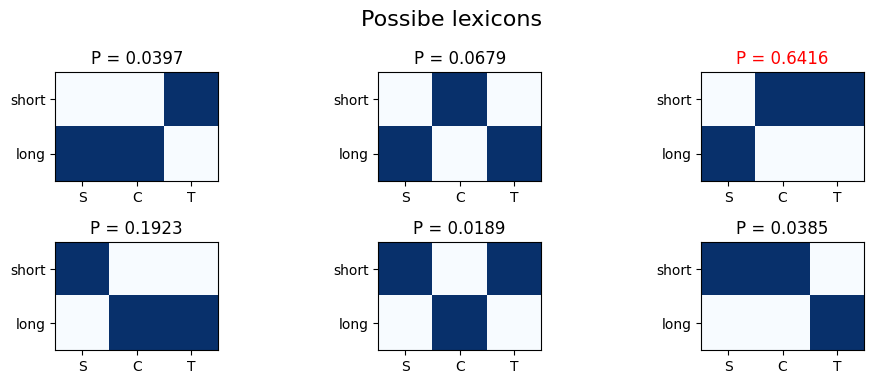

In [8]:
lexicons_ = [lexicon for lexicon, _ in lexicons]
idx = np.unique([index for _, index in lexicons])
prob_lexicons = [lexicon_probs[index] for index in idx]
un_lex = np.unique(lexicons_, axis=0)

dim = round(np.sqrt(len(un_lex))) + 1
 
# To-do: need to sort by probability
fig, ax = plt.subplots(dim, dim, figsize=(10, 5))
for i, lex in enumerate(un_lex):
    ax[i//dim, i%dim].imshow(lex, cmap='Blues')
    ax[i//dim, i%dim].xaxis.set_ticks([0, 1, 2], ['S', 'C', 'T'])
    ax[i//dim, i%dim].yaxis.set_ticks([0, 1], ['short', 'long'])
    ax[i//dim, i%dim].set_aspect('equal')
    ax[i//dim, i%dim].title.set_text(f'P = {prob_lexicons[i]:.4f}')
    # make the title red for the lexicon with maximum probability
    if prob_lexicons[i] == max(prob_lexicons):
        ax[i//dim, i%dim].title.set_color('red')
# if there is lexicon that 16, remove the remaining axes
if len(un_lex) < dim**2:
    for i in range(len(un_lex), dim**2):
        fig.delaxes(ax[i//dim, i%dim])
fig.tight_layout()
# add title
fig.suptitle('Possibe lexicons', fontsize=16, y=1.05)

In [9]:
#### NB: removing first 20 trials ####
logs_comb = pd.concat([pd.DataFrame(k).T.reset_index() for k in logs_comp]).reset_index(drop=True)

In [10]:
# group by trial and assign the last lexicon value to each trial
logs_comb_ = logs_comb.groupby('trial').last().reset_index()
# convert this into trial x lexicon dictionary
lexicon_dict = logs_comb_.groupby('trial')['lexicon'].apply(list).to_dict()

In [11]:
# apply the lexicon dictionary to the logs
logs_comb['lexicon'] = logs_comb['trial'].map(lexicon_dict)
# turn the lexicon column into a string
logs_comb['lexicon'] = logs_comb['lexicon'].apply(lambda x: x[0])

In [12]:
# if meaning is 0, the number of contexts is 2, if meanings are 1 and 2 the number of contexts is 1
logs_comb['n_contexts'] = logs_comb['meaning'].apply(lambda x: 2 if x == 0 else 1)
logs_comb['n_contexts'] = logs_comb['n_contexts'].apply(lambda x: f'{x} context' if x == 1 else f'{x} contexts')

In [13]:
logs_comb['message_length'] = logs_comb['message'].apply(lambda x: 'short' if x == 0 else 'long')
logs_comb['meaning_s'] = logs_comb['meaning'].apply(lambda x: f'm_{x}')

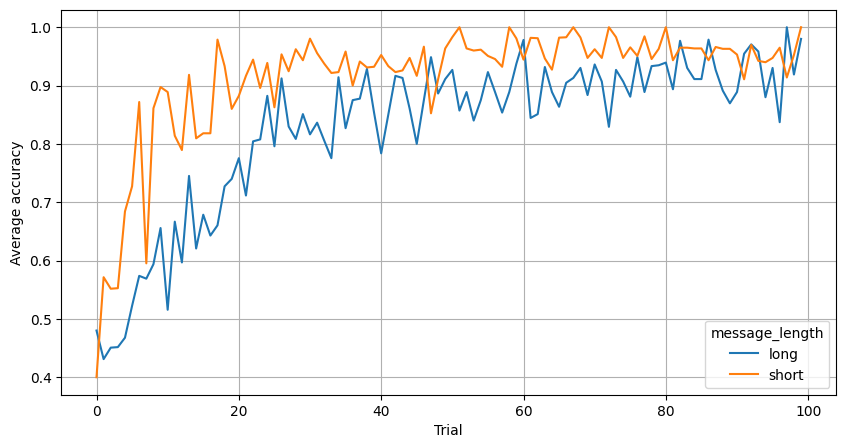

In [14]:
# group by index and plot average accuracy per index and per word
logs_comb.groupby(['index', 'message_length']).correct.mean().unstack().plot(figsize=(10, 5))
plt.xlabel('Trial')
plt.ylabel('Average accuracy')
plt.grid()

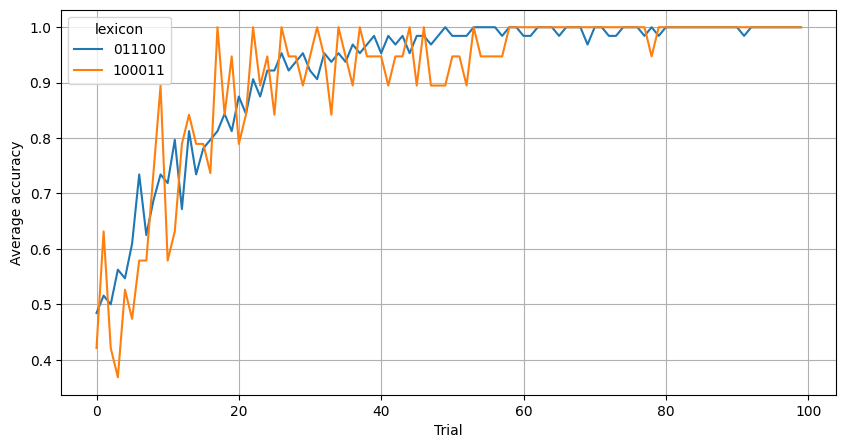

In [15]:
# plot the average accuracy per trial groupped by lexicon  (only plot the 011100 and 100011 lexicons)
logs_comb[logs_comb['lexicon'].isin(['011100', '100011'])].groupby(['lexicon', 'index']).correct.mean().unstack().T.plot(figsize=(10, 5))
plt.xlabel('Trial')
plt.ylabel('Average accuracy')
plt.grid()

Text(0, 0.5, 'Count')

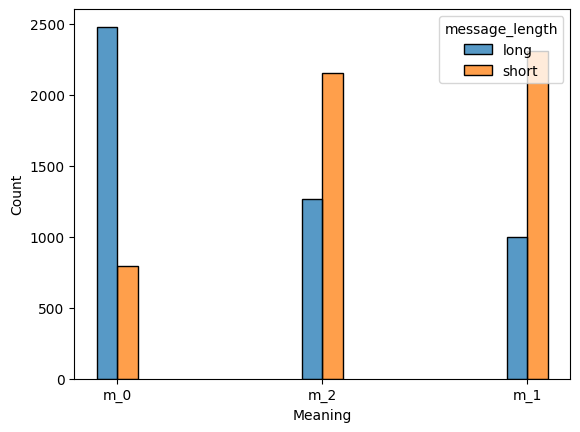

In [16]:
# plot histogram of meanings and how often short of long messages are used, order x axis by name
sns.histplot(data=logs_comb, x='meaning_s', hue='message_length', multiple='dodge', shrink=.2,)
plt.xlabel('Meaning')
plt.ylabel('Count')

Text(0, 0.5, 'Count')

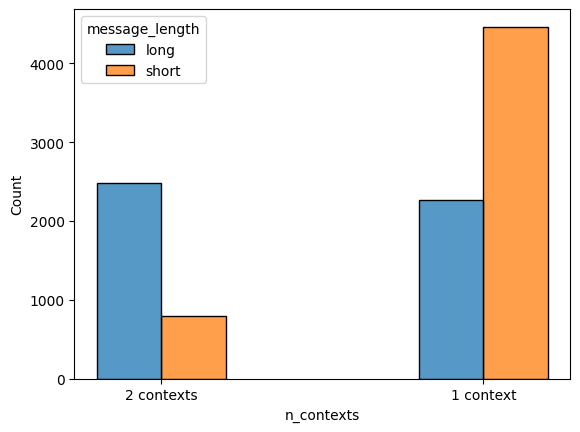

In [17]:
sns.histplot(data=logs_comb, x='n_contexts', hue='message_length', multiple='dodge', shrink=.4,)
plt.ylabel('Count')

In [18]:
# how many times a 1 context meaning was used
logs_comb[logs_comb['n_contexts'] == '1 context'].shape[0]

6729

In [19]:
dfs = [pd.DataFrame(k).T for k in logs_comp]

In [20]:
results = defaultdict(dict)

for i, df in enumerate(dfs):
    ll_ = normalized_mutual_info_score(df['meaning'], df['meaning_guess'])
    # count percentage of long word being used with meaning 0
    long_0 = df[(df['meaning'] == 0) & (df['message'] == 1)].shape[0] / df[df['meaning'] == 0].shape[0]
    # compute percentage of short word being used with meaning 1 and 2
    long_1 = df[(df['meaning'] != 0) & (df['message'] == 0)].shape[0] / df[df['meaning'] != 0].shape[0]
    # assign numerical_length to 0 as 1 and 1 as 10
    df['numerical_length'] = df['message'].apply(lambda x: 1 if x == 0 else 10)
    # write it down to results
    results[i]['cross_entropy'] = ll_
    results[i]['long_0'] = long_0
    results[i]['short_1'] = long_1
    results[i]['avg_length'] = df['numerical_length'].mean()
    results[i]['lexicon'] = df['lexicon'].iloc[-1]


In [21]:
# convert results to dataframe
results = pd.DataFrame(results).T

In [22]:
results.columns = ['cross_entropy', 'long_0', 'short_1', 'avg_length', 'lexicon']

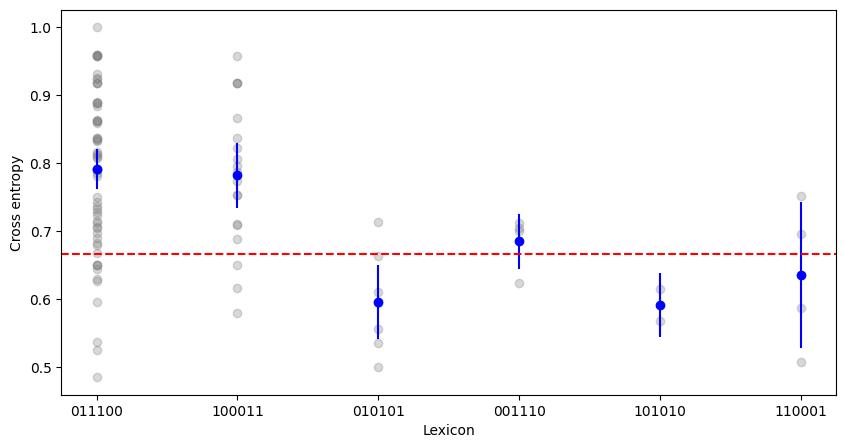

In [23]:
# plot cross entropy per lexicon using matplotlib as a bar plot
plt.figure(figsize=(10, 5))
plt.scatter(results['lexicon'], results['cross_entropy'], alpha=.3, color='grey')
# compute confidence interval per lexicon
for lex in results['lexicon'].unique():
    # get the cross entropy for each lexicon
    cross_entropy = results[results['lexicon'] == lex]['cross_entropy']
    # compute the mean and standard deviation
    mean = cross_entropy.mean()
    std = cross_entropy.std()
    # compute the confidence interval
    ci = 1.96 * std / np.sqrt(len(cross_entropy))
    # plot the mean and the confidence interval
    plt.errorbar(lex, mean, yerr=ci, fmt='o', color='blue')
plt.xlabel('Lexicon')
plt.ylabel('Cross entropy')
# plot the line crossing x at 2/3
plt.axhline(y=2/3, color='red', linestyle='--')

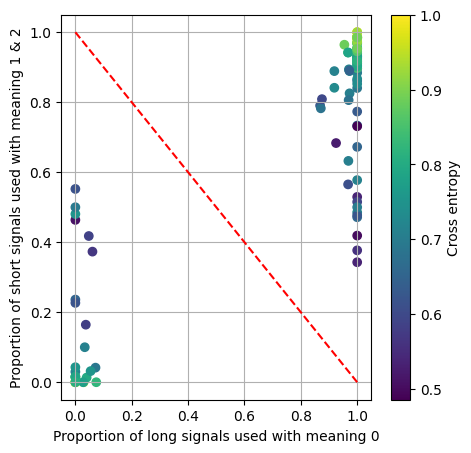

In [24]:
plt.figure(figsize=(5, 5))
plt.scatter(results['long_0'], results['short_1'], c=results['cross_entropy'])
plt.xlabel('Proportion of long signals used with meaning 0')
plt.ylabel('Proportion of short signals used with meaning 1 & 2')
plt.grid()
plt.colorbar().set_label('Cross entropy')
# add red diagonal line from 0, 1 to 1, 0 thru the plot 
plt.plot([0, 1], [1, 0], 'r--')

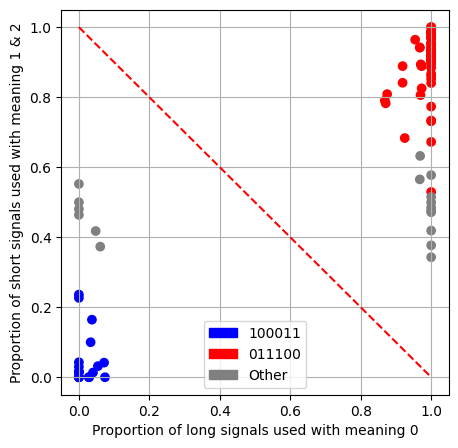

In [25]:
# color the 100011 lexicon in blue and the 011100 in red and grey if other
plt.figure(figsize=(5, 5))
plt.scatter(results['long_0'], results['short_1'], c=results['lexicon'].apply(lambda x: 'blue' if x == '100011' else 'red' if x == '011100' else 'grey'))
plt.xlabel('Proportion of long signals used with meaning 0')
plt.ylabel('Proportion of short signals used with meaning 1 & 2')
plt.grid()
# add red diagonal line from 0, 1 to 1, 0 thru the plot
plt.plot([0, 1], [1, 0], 'r--')
# add legend for the scatter plot with correct colors
plt.legend(handles=[mpatches.Patch(color='blue', label='100011'),
                    mpatches.Patch(color='red', label='011100'),
                    mpatches.Patch(color='grey', label='Other')])

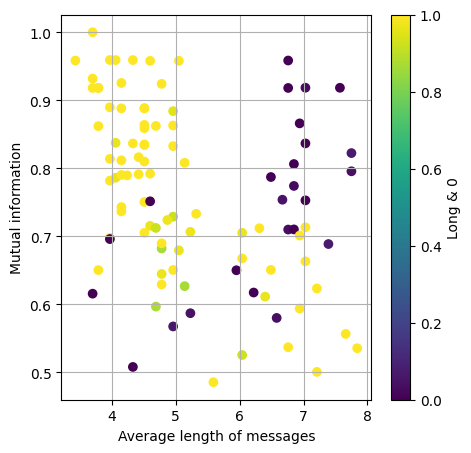

In [26]:
plt.figure(figsize=(5, 5))
plt.scatter(results['avg_length'], results['cross_entropy'], c=results['long_0'])
plt.xlabel('Average length of messages')
plt.ylabel('Mutual information')
plt.colorbar().set_label('Long & 0')
plt.grid()

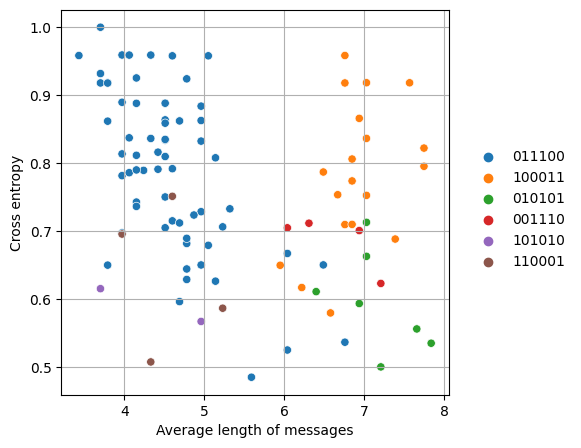

In [27]:
# plot average length of messages per lexicon vs cross entropy and color by lexicon
plt.figure(figsize=(5, 5))
sns.scatterplot(data=results, x='avg_length', y='cross_entropy', hue='lexicon')
plt.xlabel('Average length of messages')
plt.ylabel('Cross entropy')
plt.grid()
plt.legend(bbox_to_anchor=(1.05, 0.65), loc=2,  borderaxespad=0., frameon=False)

Text(33.22222222222222, 0.5, 'Message length')

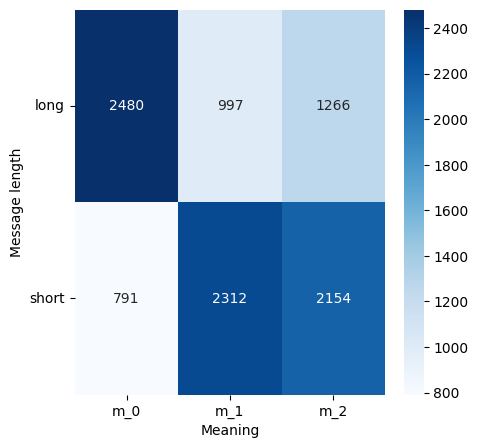

In [28]:
logs_comb['message_length'] = logs_comb['message'].apply(lambda x: 'short' if x == 0 else 'long')
logs_comb['meaning_s'] = logs_comb['meaning'].apply(lambda x: f'm_{x}')
plt.figure(figsize=(5, 5))
sns.heatmap(pd.crosstab(logs_comb['message_length'], logs_comb['meaning_s']), annot=True, fmt='d', cmap='Blues')
plt.yticks(rotation=0)
plt.xlabel('Meaning')
plt.ylabel('Message length')

### 2. Stats

In [124]:
results_ = defaultdict(dict)

for i, df in enumerate(dfs):
    results_[i]['long_0'] = df[(df['meaning'] == 0) & (df['message'] == 1)].shape[0]
    results_[i]['short_0'] = df[(df['meaning'] == 0) & (df['message'] == 0)].shape[0]
    results_[i]['used_0'] = df[(df['meaning'] == 0)].shape[0]
    results_[i]['long_1'] = df[(df['meaning'] == 1) & (df['message'] == 1)].shape[0]
    results_[i]['short_1'] = df[(df['meaning'] == 1) & (df['message'] == 0)].shape[0]
    results_[i]['used_1'] = df[(df['meaning'] == 1)].shape[0]
    results_[i]['long_2'] = df[(df['meaning'] == 2) & (df['message'] == 1)].shape[0]
    results_[i]['short_2'] = df[(df['meaning'] == 2) & (df['message'] == 0)].shape[0]
    results_[i]['used_2'] = df[(df['meaning'] == 2)].shape[0]

results_ = pd.DataFrame(results_).T

In [125]:
results_

,long_0,short_0,used_0,long_1,short_1,used_1,long_2,short_2,used_2
0,35,0,35,1,37,38,3,24,27
1,33,0,33,0,35,35,0,32,32
2,39,0,39,3,30,33,2,26,28
3,2,26,28,32,2,34,37,1,38
4,32,0,32,27,6,33,5,30,35
...,...,...,...,...,...,...,...,...,...
95,36,0,36,2,31,33,1,30,31
96,34,0,34,0,22,22,1,43,44
97,42,0,42,0,38,38,0,20,20
98,1,26,27,34,1,35,27,11,38


In [155]:
def get_trace(X, n):
    model = pm.Model()
    with model:
        p = pm.Beta( 'p', alpha=2, beta=2 )
        y_obs = pm.Binomial( 'y_obs', p=p, n=n, observed=X )
        trace = pm.sample( 1000, progressbar=True, chains=1)
        ppc = pm.sample_posterior_predictive(trace, var_names=['p'])
    return ppc, trace

In [156]:
X = results_['long_0']
n = results_['used_0']

ppc_long = get_trace(X, n)[0]

X = results_['short_0']
n = results_['used_0']

ppc_short = get_trace(X, n)[0]

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


In [157]:
ppc_long_v = ppc_long['posterior_predictive']['p']
ppc_short_v = ppc_short['posterior_predictive']['p']
# randomly sample one of the 1000 samples with repetition
diff_1 = []
for _ in range(1000):
    diff_1.append(np.random.choice(ppc_long_v[0], size=1, replace=True) - np.random.choice(ppc_short_v[0], size=1, replace=True))

In [158]:
diff_1 = np.array(diff_1).flatten()

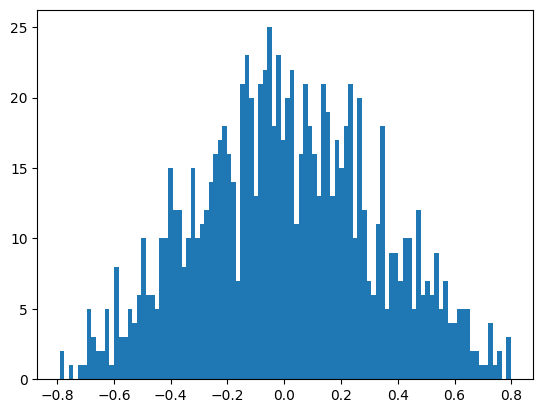

In [159]:
# plot diff_1 as a histogram
plt.hist(diff_1, bins=100)
plt.show()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.


array([[<Axes: title={'center': 'p'}>, <Axes: title={'center': 'p'}>]],
      dtype=object)

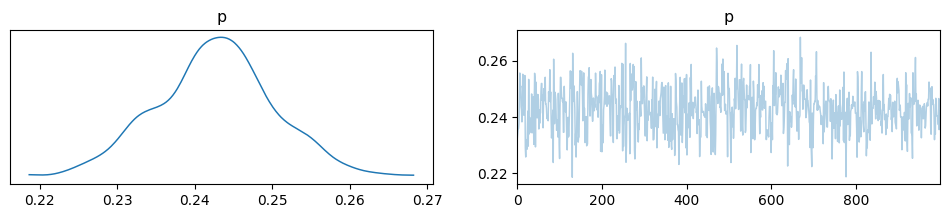

In [160]:
pm.plot_trace(get_trace(X, n)[1])

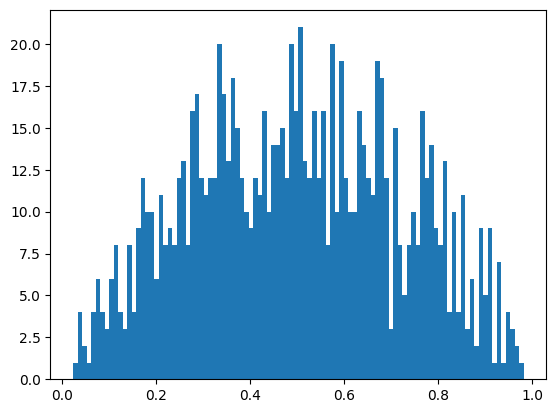

In [162]:
# plot ppc_long
plt.hist(ppc_long_v[0], bins=100)
plt.show()